In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint as odeint_torch
from generate_data import generate_data
from tqdm import tqdm
from utils import  extract_and_reset_grads
import time
import gc

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
# NN correction
class ClosureTerm(torch.nn.Module):
    def __init__(self, params):
        super(ClosureTerm, self).__init__()
        # params of the neural correction to the dynamical model (FCN model)
        self.trans_layers = params['transition_layers']
        self.transLayers = torch.nn.ModuleList([torch.nn.Linear(params['dim_state'], params['dim_hidden_dyn_mdl'])])
        self.transLayers.extend(
            [torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_hidden_dyn_mdl']) for i in
             range(1, params['transition_layers'])])
        self.out_transLayers = torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_state'])   
    
    def forward(self, x):
        for i in range(self.trans_layers):
            x = torch.tanh(self.transLayers[i](x))
        x = self.out_transLayers(x)
        return x

In [3]:
# "hybrid model"
class HybridMdl(torch.nn.Module):
    def __init__(self, params):
        super(HybridMdl, self).__init__()
        # dimensions :
        self.dim_state = params['dim_state']
        self.closure = ClosureTerm(params).to(params['device'])
        # params of the true L63 system
        self.sigma = torch.from_numpy(np.array(GD.parameters.sigma)).float().to(params['device'])
        self.rho = torch.from_numpy(np.array(GD.parameters.rho)).float().to(params['device'])
        self.beta = torch.from_numpy(np.array(GD.parameters.beta)).float().to(params['device'])
        self.nfe = 0
        
    def dyn_net(self, t, inp):
        self.nfe+=1
        grad = (torch.zeros((inp.size())).to(inp.device))
        grad[:,0] = self.sigma*(inp[:,1]-inp[:,0]);
        grad[:,1] = inp[:,0]*(self.rho-inp[:,2])-inp[:,1];
        grad[:,2] = inp[:,0]*inp[:,1] #+  self.beta*inp[:,2];
        return grad + self.closure(inp)

    def model_dt(self, inp, dt, t0=0,
                grad_mode='EGA-static'):  # flow of the ODE, assuming the flow is autonomous so t0 is always 0
        if grad_mode == 'exact':
            pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt).to(inp.device), method='dopri8')
            return pred[-1, :, :]
        elif grad_mode == 'EGA-static' or grad_mode == 'EGA-ST' or grad_mode == 'EGA-J':
            with torch.no_grad():
                # blackbox non diff solver, here an adaptive dopri solver
                self.nfe = 0
                pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt).to(inp.device), method='dopri8')
            # computational graph of the blackbox solver
            if grad_mode == 'EGA-static':
                output_p = dt * self.closure(inp.detach()) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-ST':
                output_p = dt * self.closure(inp) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-J':
                output_p = dt * self.dyn_net(t0+dt,inp) + inp
                output_p.data = pred.data[-1, :, :]                
            return output_p
    def forward(self, dt, n, x0, grad_mode='EGA'):
        pred = [x0]
        for i in range(n):
            pred.append(self.model_dt(pred[-1], dt, grad_mode=grad_mode))
        pred_seq = torch.stack(pred)[:, :, :]
        return pred_seq

In [4]:
convergence_diag = {'n_steps': [5,50,100,300,500,800,1000],'time_steps': [0.01],'error_EGA_ST': [], 'error_EGA_Static': [], 'error_EGA_J_Euler': [], 'norm_error_EGA_ST': [], 'norm_error_EGA_Static': [], 'norm_error_EGA_J_Euler': [], 'time_comp_graph': [], 'time_EGA_static': [], 'time_EGA_J_Euler': [], 'time_EGA_ST': [], 'mem_comp_graph': [], 'mem_EGA_static': [], 'mem_EGA_J_Euler': [], 'mem_EGA_ST': [], 'mem_forward_comp_graph': [], 'mem_forward_EGA_static': [], 'mem_forward_EGA_J_Euler': [], 'mem_forward_EGA_ST': [], 'nfe': []}

In [5]:
# Generate Lorenz 63 simulations
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = convergence_diag['time_steps'][0]
    nb_loop_data = 60.0

# run the data generation
dataset = generate_data(GD)

In [6]:
for i in tqdm(range(len(convergence_diag['n_steps']))):
    params = {'dt_integration': convergence_diag['time_steps'][0], 'dim_state': 3, 'dim_output': 3, 'transition_layers': 2,
              'dim_hidden_dyn_mdl': 3, 'device': 'cuda', 'Batch_size': 128, 
              'seed': 0, 'n_steps': convergence_diag['n_steps'][i]}
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    
    # make sure we use the same number of initial conditions per time resolution
    rat_data = int(convergence_diag['time_steps'][-1]/params['dt_integration'])
    subsampling = int(params['dt_integration']/convergence_diag['time_steps'][0])
    X_train = torch.from_numpy(dataset[::subsampling][::rat_data]).float()
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=params['Batch_size'], shuffle=False, pin_memory=False, drop_last=True)
    
    # hybrid model
    hybrid_model = HybridMdl(params)

    # EGA static
    time_batch_ega_static, grads_EGA_Static, mem_ega_static, mem_forward_ega_static = [], [], [], []
    time_batch_ega_J_euler, grads_EGA_J_Euler, mem_ega_J_euler, mem_forward_ega_J_euler = [], [], [], []
    time_batch_ega_ST, grads_EGA_ST, mem_ega_ST, mem_forward_ega_ST = [], [], [], []
    time_batch_comp_G, grads_GT, mem_comp_G, mem_forward_ega_comp_G = [], [], [], []
    nfe_batch = []
    
    for x_data in train_loader:
        x_data = x_data.to(params['device'])

        # EGA static
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_forward_ega_static = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        with torch.no_grad():
            pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-static')
            nfe_batch.append(hybrid_model.nfe)
            hybrid_model.nfe = 0
        torch.cuda.synchronize()
        end_mem_forward_ega_static = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        # Clean up
        del pred_mdl
        torch.cuda.empty_cache()
        gc.collect()   
        mem_forward_ega_static.append(end_mem_forward_ega_static - start_mem_forward_ega_static)
        
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_ega_static = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-static')
        torch.cuda.synchronize()
        end_mem_ega_static = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_static = time.time()
        error1.backward()
        end_time_ega_static = time.time()
        
        time_batch_ega_static.append(end_time_ega_static - start_time_ega_static)
        mem_ega_static.append(end_mem_ega_static - start_mem_ega_static)  # Corrected memory usage calculation
        grads_EGA_Static.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())
        
        # Clean up
        del pred_mdl, error1
        torch.cuda.empty_cache()
        gc.collect()

        # EGA Jacobian Euler
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_forward_ega_J_euler = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        with torch.no_grad():
            pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-J')
        torch.cuda.synchronize()
        end_mem_forward_ega_J_euler = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        # Clean up
        del pred_mdl
        torch.cuda.empty_cache()
        gc.collect()   
        mem_forward_ega_J_euler.append(end_mem_forward_ega_J_euler - start_mem_forward_ega_J_euler)
        
        
        
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_ega_J_euler = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-J')
        torch.cuda.synchronize()
        end_mem_ega_J_euler = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_J_euler = time.time()
        error1.backward()
        end_time_ega_J_euler = time.time()
        
        time_batch_ega_J_euler.append(end_time_ega_J_euler - start_time_ega_J_euler)
        mem_ega_J_euler.append(end_mem_ega_J_euler - start_mem_ega_J_euler)  # Corrected memory usage calculation
        grads_EGA_J_Euler.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())
        
        # Clean up
        del pred_mdl, error1
        torch.cuda.empty_cache()
        gc.collect()

        # EGA straight through (keep the jacobian term of the NN model)
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_forward_ega_ST = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        with torch.no_grad():
            pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-ST')
        torch.cuda.synchronize()
        end_mem_forward_ega_ST = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        # Clean up
        del pred_mdl
        torch.cuda.empty_cache()
        gc.collect()   
        mem_forward_ega_ST.append(end_mem_forward_ega_ST - start_mem_forward_ega_ST)
        
                
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_ega_ST = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-ST')
        torch.cuda.synchronize()
        end_mem_ega_ST = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_ST = time.time()
        error1.backward()
        end_time_ega_ST = time.time()
        
        time_batch_ega_ST.append(end_time_ega_ST - start_time_ega_ST)
        mem_ega_ST.append(end_mem_ega_ST - start_mem_ega_ST)  # Corrected memory usage calculation
        grads_EGA_ST.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())
        
        # Clean up
        del pred_mdl, error1
        torch.cuda.empty_cache()
        gc.collect()

        # Exact gradient of the solver
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_forward_ega_comp_G = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        with torch.no_grad():
            pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='exact')
        torch.cuda.synchronize()
        end_mem_forward_ega_comp_G = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        # Clean up
        del pred_mdl
        torch.cuda.empty_cache()
        gc.collect()   
        mem_forward_ega_comp_G.append(end_mem_forward_ega_comp_G - start_mem_forward_ega_comp_G)
        
        
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_comp_G = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='exact')
        torch.cuda.synchronize()
        end_mem_comp_G = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_comp_G = time.time()
        error1.backward()
        end_time_ega_comp_G = time.time()
        
        time_batch_comp_G.append(end_time_ega_comp_G - start_time_ega_comp_G)
        mem_comp_G.append(end_mem_comp_G - start_mem_comp_G)  # Corrected memory usage calculation
        grads_GT.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())
        
        # Clean up
        del pred_mdl, error1
        torch.cuda.empty_cache()
        gc.collect()
    convergence_diag['nfe'].append(np.array(nfe_batch))
    # compute gradient errors
    convergence_diag['error_EGA_ST'].append(np.array(grads_GT) - np.array(grads_EGA_ST)) 
    convergence_diag['error_EGA_Static'].append(np.array(grads_GT) - np.array(grads_EGA_Static)) 
    convergence_diag['error_EGA_J_Euler'].append(np.array(grads_GT) - np.array(grads_EGA_J_Euler)) 

    norm_grad = np.abs(np.array(grads_GT))
    norm_grad[np.where(np.abs(np.array(grads_GT))<1E-3)] = np.nan
    convergence_diag['norm_error_EGA_ST'].append(np.abs(np.array(grads_GT) - np.array(grads_EGA_ST))/norm_grad) 
    convergence_diag['norm_error_EGA_Static'].append(np.abs(np.array(grads_GT) - np.array(grads_EGA_Static))/norm_grad) 
    convergence_diag['norm_error_EGA_J_Euler'].append(np.abs(np.array(grads_GT) - np.array(grads_EGA_J_Euler))/norm_grad) 

    convergence_diag['time_comp_graph'].append(np.array(time_batch_comp_G)) 
    convergence_diag['time_EGA_static'].append(np.array(time_batch_ega_static)) 
    convergence_diag['time_EGA_J_Euler'].append(np.array(time_batch_ega_J_euler)) 
    convergence_diag['time_EGA_ST'].append(np.array(time_batch_ega_ST)) 

    # store memory usage total
    convergence_diag['mem_comp_graph'].append(np.array(mem_comp_G))
    convergence_diag['mem_EGA_static'].append(np.array(mem_ega_static))
    convergence_diag['mem_EGA_J_Euler'].append(np.array(mem_ega_J_euler))
    convergence_diag['mem_EGA_ST'].append(np.array(mem_ega_ST))
    
    # store memory usage forward pass
    convergence_diag['mem_forward_comp_graph'].append(np.array(mem_forward_ega_comp_G))
    convergence_diag['mem_forward_EGA_static'].append(np.array(mem_forward_ega_static))
    convergence_diag['mem_forward_EGA_J_Euler'].append(np.array(mem_forward_ega_J_euler))
    convergence_diag['mem_forward_EGA_ST'].append(np.array(mem_forward_ega_ST))


100%|██████████| 7/7 [13:58:30<00:00, 7187.17s/it] 


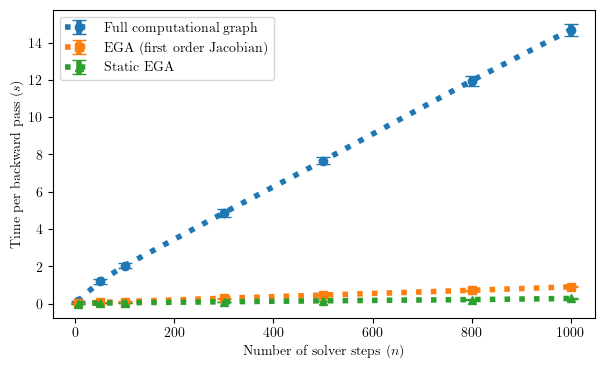

In [31]:
# Compute means and standard deviations
n_steps = convergence_diag['n_steps']
time_comp_graph = np.array(convergence_diag['time_comp_graph'])
time_EGA_J_Euler = np.array(convergence_diag['time_EGA_J_Euler'])
time_EGA_static = np.array(convergence_diag['time_EGA_static'])

mean_comp_graph = time_comp_graph.mean(axis=-1)
std_comp_graph = time_comp_graph.std(axis=-1)

mean_EGA_J_Euler = time_EGA_J_Euler.mean(axis=-1)
std_EGA_J_Euler = time_EGA_J_Euler.std(axis=-1)

mean_EGA_static = time_EGA_static.mean(axis=-1)
std_EGA_static = time_EGA_static.std(axis=-1)

plt.figure(figsize=(7,4))
# Plot with error bars (dots only, no connecting lines)
plt.errorbar(n_steps, mean_comp_graph, yerr=std_comp_graph, linestyle = 'dotted', label='Full computational graph', fmt='o', capsize=5, lw= 4)
plt.errorbar(n_steps, mean_EGA_J_Euler, yerr=std_EGA_J_Euler, linestyle = 'dotted', label='EGA (first order Jacobian)', fmt='s', capsize=5, lw= 4)
plt.errorbar(n_steps, mean_EGA_static, yerr=std_EGA_static, linestyle = 'dotted', label='Static EGA', fmt='^', capsize=5, lw= 4)

# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('Time per backward pass $(s)$')
plt.legend()

plt.savefig("output_figures/time_backward_pass_dopri8.png")
plt.savefig("output_figures/time_backward_pass_dopri8.svg")
plt.savefig("output_figures/time_backward_pass_dopri8.pdf")
plt.show()

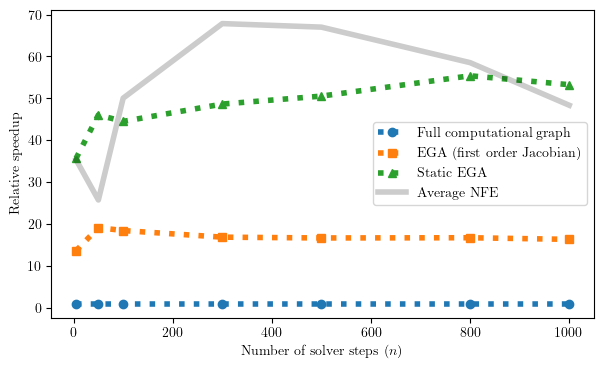

In [36]:
# Compute means and standard deviations
n_steps = convergence_diag['n_steps']
time_comp_graph = np.array(convergence_diag['time_comp_graph'])
time_EGA_J_Euler = np.array(convergence_diag['time_EGA_J_Euler'])
time_EGA_static = np.array(convergence_diag['time_EGA_static'])

time_comp_graph_speedup = time_comp_graph/time_comp_graph
time_EGA_J_Euler_speedup = time_comp_graph/time_EGA_J_Euler
time_EGA_static_speedup = time_comp_graph/time_EGA_static

mean_comp_graph = time_comp_graph_speedup.mean(axis=-1)
std_comp_graph = time_comp_graph_speedup.std(axis=-1)

mean_EGA_J_Euler = time_EGA_J_Euler_speedup.mean(axis=-1)
std_EGA_J_Euler = time_EGA_J_Euler_speedup.std(axis=-1)

mean_EGA_static = time_EGA_static_speedup.mean(axis=-1)
std_EGA_static = time_EGA_static_speedup.std(axis=-1)

plt.figure(figsize=(7,4))
# Plot with error bars (dots only, no connecting lines)
plt.plot(n_steps, mean_comp_graph,  linestyle = 'dotted', label='Full computational graph', marker='o', lw= 4)
plt.plot(n_steps, mean_EGA_J_Euler,  linestyle = 'dotted', label='EGA (first order Jacobian)', marker='s',  lw= 4)
plt.plot(n_steps, mean_EGA_static, linestyle = 'dotted', label='Static EGA', marker='^',  lw= 4)
plt.plot(n_steps, np.array(convergence_diag['nfe']).mean(axis = -1),alpha = 0.2, lw= 4, label='Average NFE', c = 'k')

# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('Relative speedup')
plt.legend()

plt.savefig("output_figures/Relative_speedup_dopri8.png")
plt.savefig("output_figures/Relative_speedup_dopri8.svg")
plt.savefig("output_figures/Relative_speedup_dopri8.pdf")
plt.show()

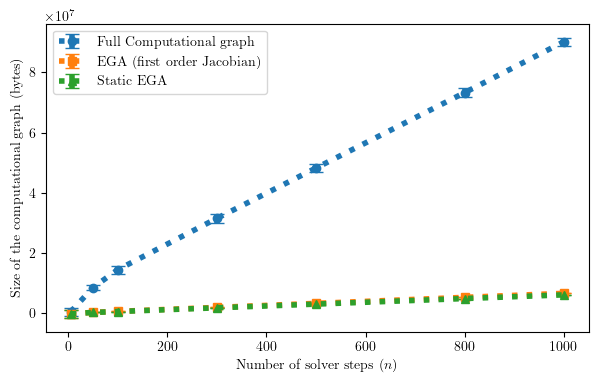

In [33]:
# Compute means and standard deviations
n_steps = convergence_diag['n_steps']
mem_comp_graph = np.array(convergence_diag['mem_comp_graph']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_J_Euler = np.array(convergence_diag['mem_EGA_J_Euler']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_static = np.array(convergence_diag['mem_EGA_static']) - np.array(convergence_diag['mem_forward_EGA_static'])

mean_comp_graph = mem_comp_graph.mean(axis=-1)
std_comp_graph = mem_comp_graph.std(axis=-1)

mean_EGA_J_Euler = mem_EGA_J_Euler.mean(axis=-1)
std_EGA_J_Euler = mem_EGA_J_Euler.std(axis=-1)

mean_EGA_static = mem_EGA_static.mean(axis=-1)
std_EGA_static = mem_EGA_static.std(axis=-1)

plt.figure(figsize=(7,4))
# Plot with error bars (dots only, no connecting lines)
plt.errorbar(n_steps, mean_comp_graph, yerr=std_comp_graph, linestyle = 'dotted', label='Full Computational graph', fmt='o', capsize=5, lw= 4)
plt.errorbar(n_steps, mean_EGA_J_Euler, yerr=std_EGA_J_Euler, linestyle = 'dotted', label='EGA (first order Jacobian)', fmt='s', capsize=5, lw= 4)
plt.errorbar(n_steps, mean_EGA_static, yerr=std_EGA_static, linestyle = 'dotted', label='Static EGA', fmt='^', capsize=5, lw= 4)

# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('Size of the computational graph (bytes)')
plt.legend()

plt.savefig("output_figures/size_of_comp_graph_dopri8.png")
plt.savefig("output_figures/size_of_comp_graph_dopri8.svg")
plt.savefig("output_figures/size_of_comp_graph_dopri8.pdf")
plt.show()

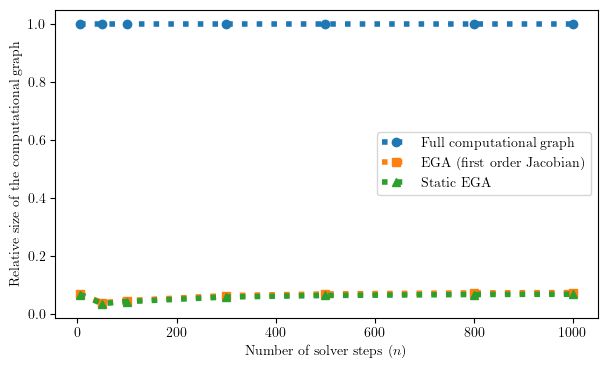

In [34]:
# Compute means and standard deviations
n_steps = convergence_diag['n_steps']
mem_comp_graph = np.array(convergence_diag['mem_comp_graph']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_J_Euler = np.array(convergence_diag['mem_EGA_J_Euler']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_static = np.array(convergence_diag['mem_EGA_static']) - np.array(convergence_diag['mem_forward_EGA_static'])

mem_comp_graph_ratio = mem_comp_graph/mem_comp_graph
mem_EGA_J_Euler_ratio = mem_EGA_J_Euler/mem_comp_graph
mem_EGA_static_ratio = mem_EGA_static/mem_comp_graph

mean_comp_graph = mem_comp_graph_ratio.mean(axis=-1)
std_comp_graph = mem_comp_graph_ratio.std(axis=-1)

mean_EGA_J_Euler = mem_EGA_J_Euler_ratio.mean(axis=-1)
std_EGA_J_Euler = mem_EGA_J_Euler_ratio.std(axis=-1)

mean_EGA_static = mem_EGA_static_ratio.mean(axis=-1)
std_EGA_static = mem_EGA_static_ratio.std(axis=-1)

plt.figure(figsize=(7,4))
# Plot with error bars (dots only, no connecting lines)
plt.plot(n_steps, mean_comp_graph,  linestyle = 'dotted', label='Full computational graph', marker='o', lw= 4)
plt.plot(n_steps, mean_EGA_J_Euler,  linestyle = 'dotted', label='EGA (first order Jacobian)', marker='s',  lw= 4)
plt.plot(n_steps, mean_EGA_static, linestyle = 'dotted', label='Static EGA', marker='^',  lw= 4)

# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('Relative size of the computational graph')
plt.legend()

plt.savefig("output_figures/relative_size_of_comp_graph_dopri8.png")
plt.savefig("output_figures/relative_size_of_comp_graph_dopri8.svg")
plt.savefig("output_figures/relative_size_of_comp_graph_dopri8.pdf")
plt.show()

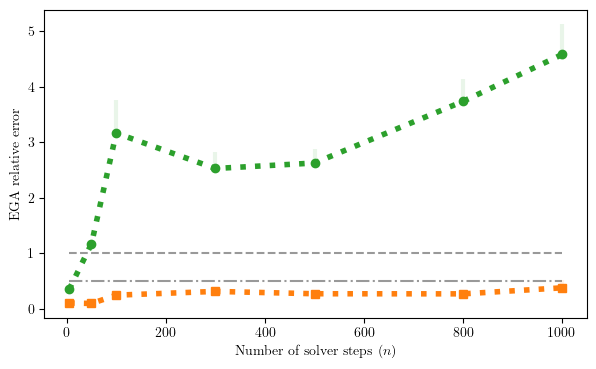

In [41]:
factor_div_std = 50
n_steps = convergence_diag['n_steps']
mean_EGA_Static = np.nanmean(np.abs(np.array(convergence_diag['norm_error_EGA_Static'])).reshape(len(n_steps), -1),axis=-1)
mean_EGA_J_Euler = np.nanmean(np.abs(np.array(convergence_diag['norm_error_EGA_J_Euler'])).reshape(len(n_steps), -1),axis=-1)

std_EGA_Static = np.nanstd(np.abs(np.array(convergence_diag['norm_error_EGA_Static'])).reshape(len(n_steps), -1),axis=-1)
std_EGA_J_Euler = np.nanstd(np.abs(np.array(convergence_diag['norm_error_EGA_J_Euler'])).reshape(len(n_steps), -1),axis=-1)

error_EGA_Static_min = np.ones((len(n_steps)))*std_EGA_Static/factor_div_std
error_EGA_Static_min[np.where(mean_EGA_Static - std_EGA_Static<0)] = mean_EGA_Static[np.where(mean_EGA_Static - std_EGA_Static<0)]/factor_div_std
error_EGA_Static = np.array([error_EGA_Static_min, std_EGA_Static/factor_div_std])

error_EGA_J_Euler_min = np.ones((len(n_steps)))*std_EGA_J_Euler/factor_div_std
error_EGA_J_Euler_min[np.where(mean_EGA_J_Euler - std_EGA_J_Euler<0)] = mean_EGA_J_Euler[np.where(mean_EGA_J_Euler - std_EGA_J_Euler<0)]/factor_div_std
error_EGA_J_Euler = np.array([error_EGA_J_Euler_min, std_EGA_J_Euler/factor_div_std])

fig, ax = plt.subplots(figsize=(7,4))
plt.plot(n_steps, np.array(n_steps)*0+1,linestyle = 'dashed', label = 'Threshold 100 % ', alpha = 0.4, c ='k')
plt.plot(n_steps, np.array(n_steps)*0+0.5,linestyle = 'dashdot', label = 'Threshold 50 % ', alpha = 0.4, c ='k')
plt.plot(n_steps, np.array(n_steps)*np.nan)
markers2, caps2, bars2 = ax.errorbar(n_steps, mean_EGA_J_Euler, yerr=error_EGA_J_Euler, linestyle = 'dotted', label='EGA (first order Jacobian)', fmt='s',elinewidth=3,capsize=0, lw= 4)
markers, caps, bars = ax.errorbar(n_steps, mean_EGA_Static, yerr=error_EGA_Static, linestyle = 'dotted', label='Static EGA',elinewidth=3, capsize=0, fmt='o', lw= 4)


[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

[bar.set_alpha(0.1) for bar in bars2]
[cap.set_alpha(0.1) for cap in caps2]
# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('EGA relative error')
#plt.legend()

plt.savefig("output_figures/relative_error_EGA_DOPRI8.png")
plt.savefig("output_figures/relative_error_EGA_DOPRI8.svg")
plt.savefig("output_figures/relative_error_EGA_DOPRI8.pdf")
plt.show()